In [1]:
import pickle as pkl
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from emle.models import EMLE
from emle.train._utils import pad_to_max
from scipy.stats import kendalltau, pearsonr
from sklearn.metrics import r2_score

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [2]:
def calculate_rmse(predicted, reference):
    """
    Calculate the root mean squared error (RMSE) between predicted and reference values.

    Parameters
    ----------
    predicted : numpy.ndarray
        The predicted values.
    reference : numpy.ndarray

    Returns
    -------
    rmse : float
        The root mean squared error.
    """
    return np.sqrt(np.mean((predicted - reference) ** 2))


def compute_metrics(true_values, predicted_values):
    """
    Compute the mean unsigned error (MUE), mean signed error (MSE), Kendall's tau,
    Pearson's correlation, R^2, and root mean squared error (RMSE) between true and predicted values.

    Parameters
    ----------
    true_values : numpy.ndarray
        The true values.
    predicted_values : numpy.ndarray
        The predicted values.

    Returns
    -------
    mue : float
        The mean unsigned error.
    mse : float
        The mean signed error.
    kendall : float
        The Kendall's tau.
    pearson : float
        The Pearson's correlation.
    r2 : float
        The R^2 score.
    rmse : float
        The root mean squared error.
    """

    mue = np.mean(np.abs(predicted_values - true_values))
    mse = np.mean(predicted_values - true_values)
    kendall = kendalltau(true_values, predicted_values)[0]
    pearson = pearsonr(true_values, predicted_values)[0]
    r2 = r2_score(true_values, predicted_values)
    rmse = calculate_rmse(predicted_values, true_values)

    return mue, mse, kendall, pearson, r2, rmse

# Load Data

In [3]:
# Set the path to the models
source_path = "../../../"

models_dict = {
    "General Model": source_path + "emle_models/emle_qm7_aev.mat",
    "Bespoke Model": source_path + "emle_models/ligand_bespoke_iter2.mat",
    "Patched Model": source_path + "emle_models/ligand_patched_species_iter2.mat",
}

# Load the testing data
testing_data = [
    source_path + "data/testing_datasets/testing_data_iter1.pkl",
    source_path + "data/testing_datasets/testing_data_iter2.pkl",
    source_path + "data/testing_datasets/testing_data_iter3.pkl",
]

# Initialize lists to store data
xyz_qm, xyz_mm, z, charges_mm = [], [], [], []
s, q_core, q_val, alpha = [], [], [], []

for data in testing_data:
    testing_data = pkl.load(open(data, "rb"))
    xyz_qm += testing_data["xyz_qm"]
    xyz_mm += testing_data["xyz_mm"]
    z += testing_data["z"]
    charges_mm += testing_data["charges_mm"]

    s += testing_data["s"]
    q_core += testing_data["q_core"]
    q_val += testing_data["q_val"]
    alpha += testing_data["alpha"]

# Pad to max and convert to torch tensors
xyz_qm = pad_to_max(xyz_qm)
xyz_mm = pad_to_max(xyz_mm)
z = pad_to_max(z)
charges_mm = pad_to_max(charges_mm)
s_ref = pad_to_max(s)
q_core_ref = pad_to_max(q_core)
q_val_ref = pad_to_max(q_val)
alpha_ref = pad_to_max(alpha)

In [4]:
# Evaluate the EMLE energy for each model
emle_mbis_dict = {}

for model_name, model_path in models_dict.items():
    emle_model = EMLE(model=model_path, alpha_mode="species").double()
    emle_base = emle_model._emle_base

    s_emle, q_core_emle, q_val_emle, A_thole_emle = emle_base.forward(
        z, xyz_qm, torch.zeros(len(xyz_qm))
    )

    # Calculate molecular polarizability
    mask = z > 0
    n_atoms = mask.shape[1]
    mask_mat = (
        (mask[:, :, None] * mask[:, None, :])
        .repeat_interleave(3, dim=1)
        .repeat_interleave(3, dim=2)
    )

    A_thole_inv = torch.where(mask_mat, torch.linalg.inv(A_thole_emle), 0.0)
    alpha_emle = (
        torch.sum(A_thole_inv.reshape((-1, n_atoms, 3, n_atoms, 3)), dim=(1, 3))
        .detach()
        .numpy()
    )

    emle_mbis_dict[model_name] = {
        "s": s_emle.detach().numpy(),
        "q_core": q_core_emle.detach().numpy(),
        "q_val": q_val_emle.detach().numpy(),
        "alpha": alpha_emle,
        "z": z.detach().numpy(),
    }

# Save the dictionary to a file
# with open("emle_mbis_qm_dict.pkl", "wb") as f:
#     pkl.dump(emle_mbis_dict, f)

# Total Charge Prediction Performance

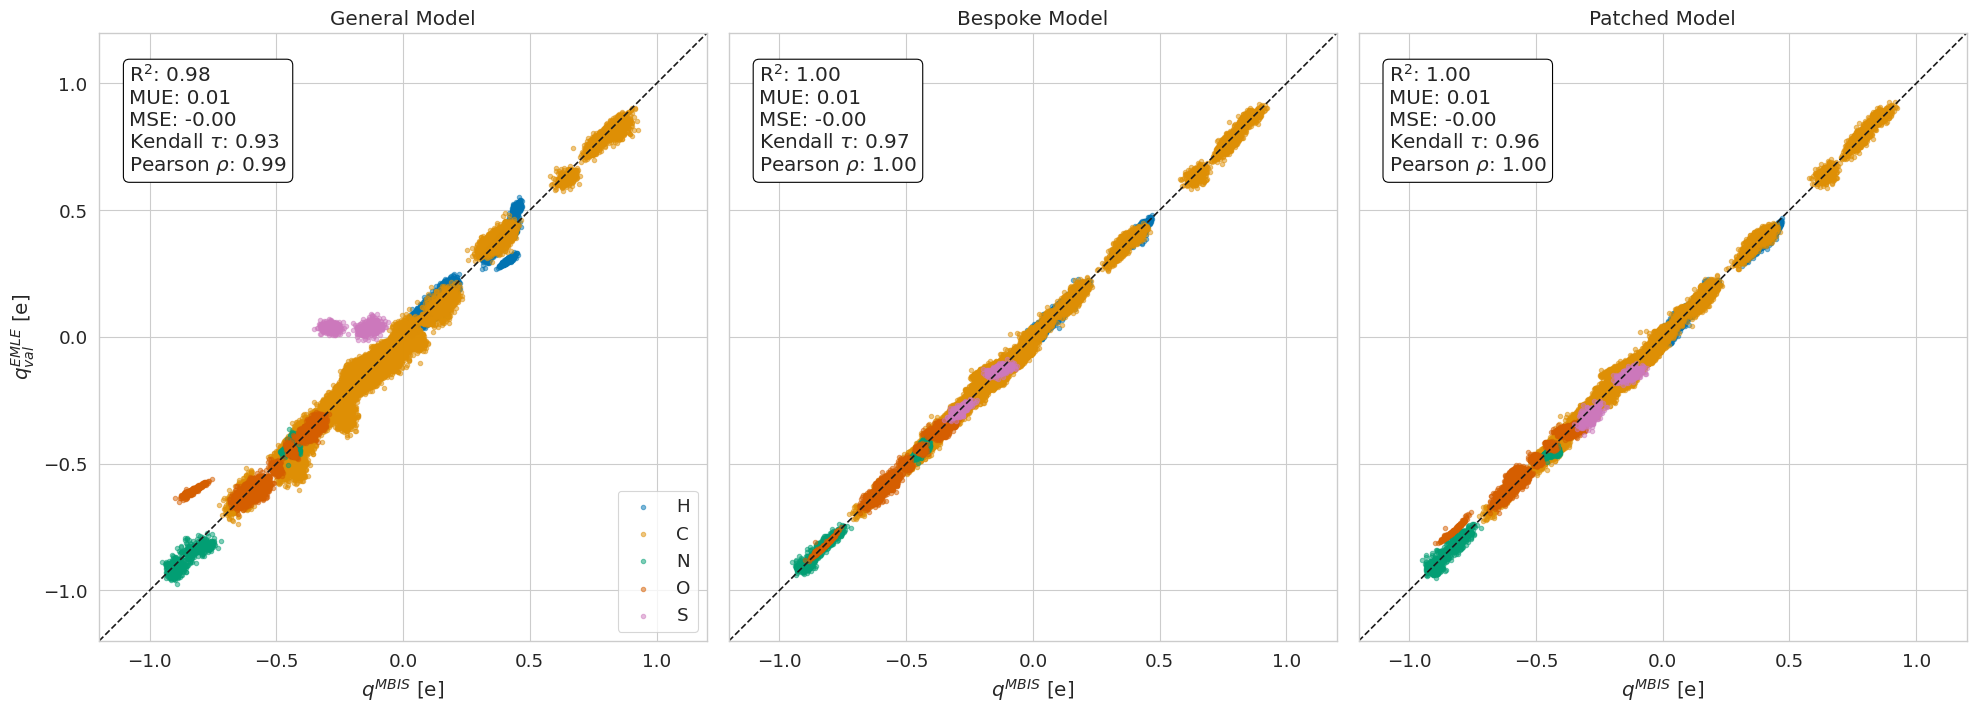

In [5]:
# Set up the plot style and figure
sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.5)
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True, sharey=True)

# Define plot limits and reference line
xlims = ylims = (-1.2, 1.2)
x = y = np.linspace(*xlims, 100)

# Create atomic masks for filtering
atomic_masks = {
    "H": z.flatten() == 1,
    "C": z.flatten() == 6,
    "N": z.flatten() == 7,
    "O": z.flatten() == 8,
    "S": z.flatten() == 16,
}

# Plot for each model
for i, (model_name, mbis) in enumerate(emle_mbis_dict.items()):
    ax = axes[i]
    ax.set_aspect("equal")
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.plot(x, y, "k--")

    # Calculate total charges (valence + core)
    predicted = mbis["q_val"].flatten() + mbis["q_core"].flatten()
    reference = q_val_ref.detach().flatten() + q_core_ref.flatten()

    mue, mse, kendall, pearson, r2, rmse = compute_metrics(
        reference.detach().numpy(), predicted
    )

    # Plot scatter points for each model and element
    for atom, mask in atomic_masks.items():
        ax.scatter(reference[mask], predicted[mask], label=atom, alpha=0.5, s=10)

    ax.set_xlabel("$q^{MBIS}$ [e]")
    ax.set_title(model_name)

    metrics_text = (
        f"R$^2$: {r2:.2f}\n"
        f"MUE: {mue:.2f}\n"
        f"MSE: {mse:.2f}\n"
        f"Kendall $\\tau$: {kendall:.2f}\n"
        f"Pearson $\\rho$: {pearson:.2f}"
    )
    ax.text(
        0.05,
        0.95,
        metrics_text,
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
    )

axes[0].legend()
axes[0].set_ylabel("$q_{val}^{EMLE}$ [e]")

plt.tight_layout()
# plt.savefig("total_charge_prediction_performance.pdf", dpi=300, bbox_inches="tight")

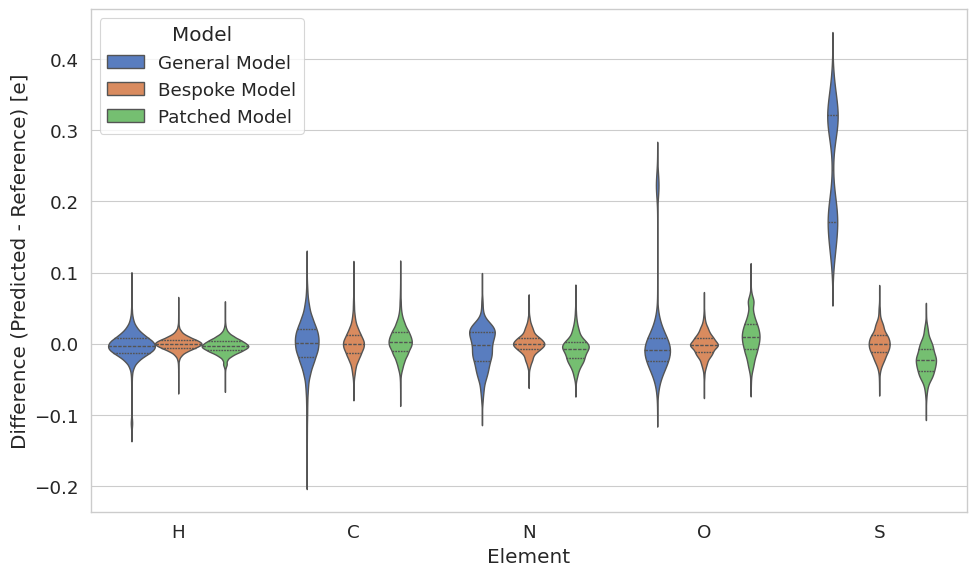

In [6]:
data = []
for model_name, mbis in emle_mbis_dict.items():
    predicted = mbis["q_val"].flatten() + mbis["q_core"].flatten()
    reference = q_val_ref.detach().flatten() + q_core_ref.flatten()
    diff = predicted - reference.numpy()

    for atom, mask in atomic_masks.items():
        data.extend(
            [{"Model": model_name, "Atom": atom, "Difference": v} for v in diff[mask]]
        )

df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="Atom",
    y="Difference",
    hue="Model",
    data=df,
    split=False,
    inner="quart",
    palette="muted",
)
plt.xlabel("Element")
plt.ylabel("Difference (Predicted - Reference) [e]")
plt.tight_layout()
plt.show()

# Core Charge Distribution

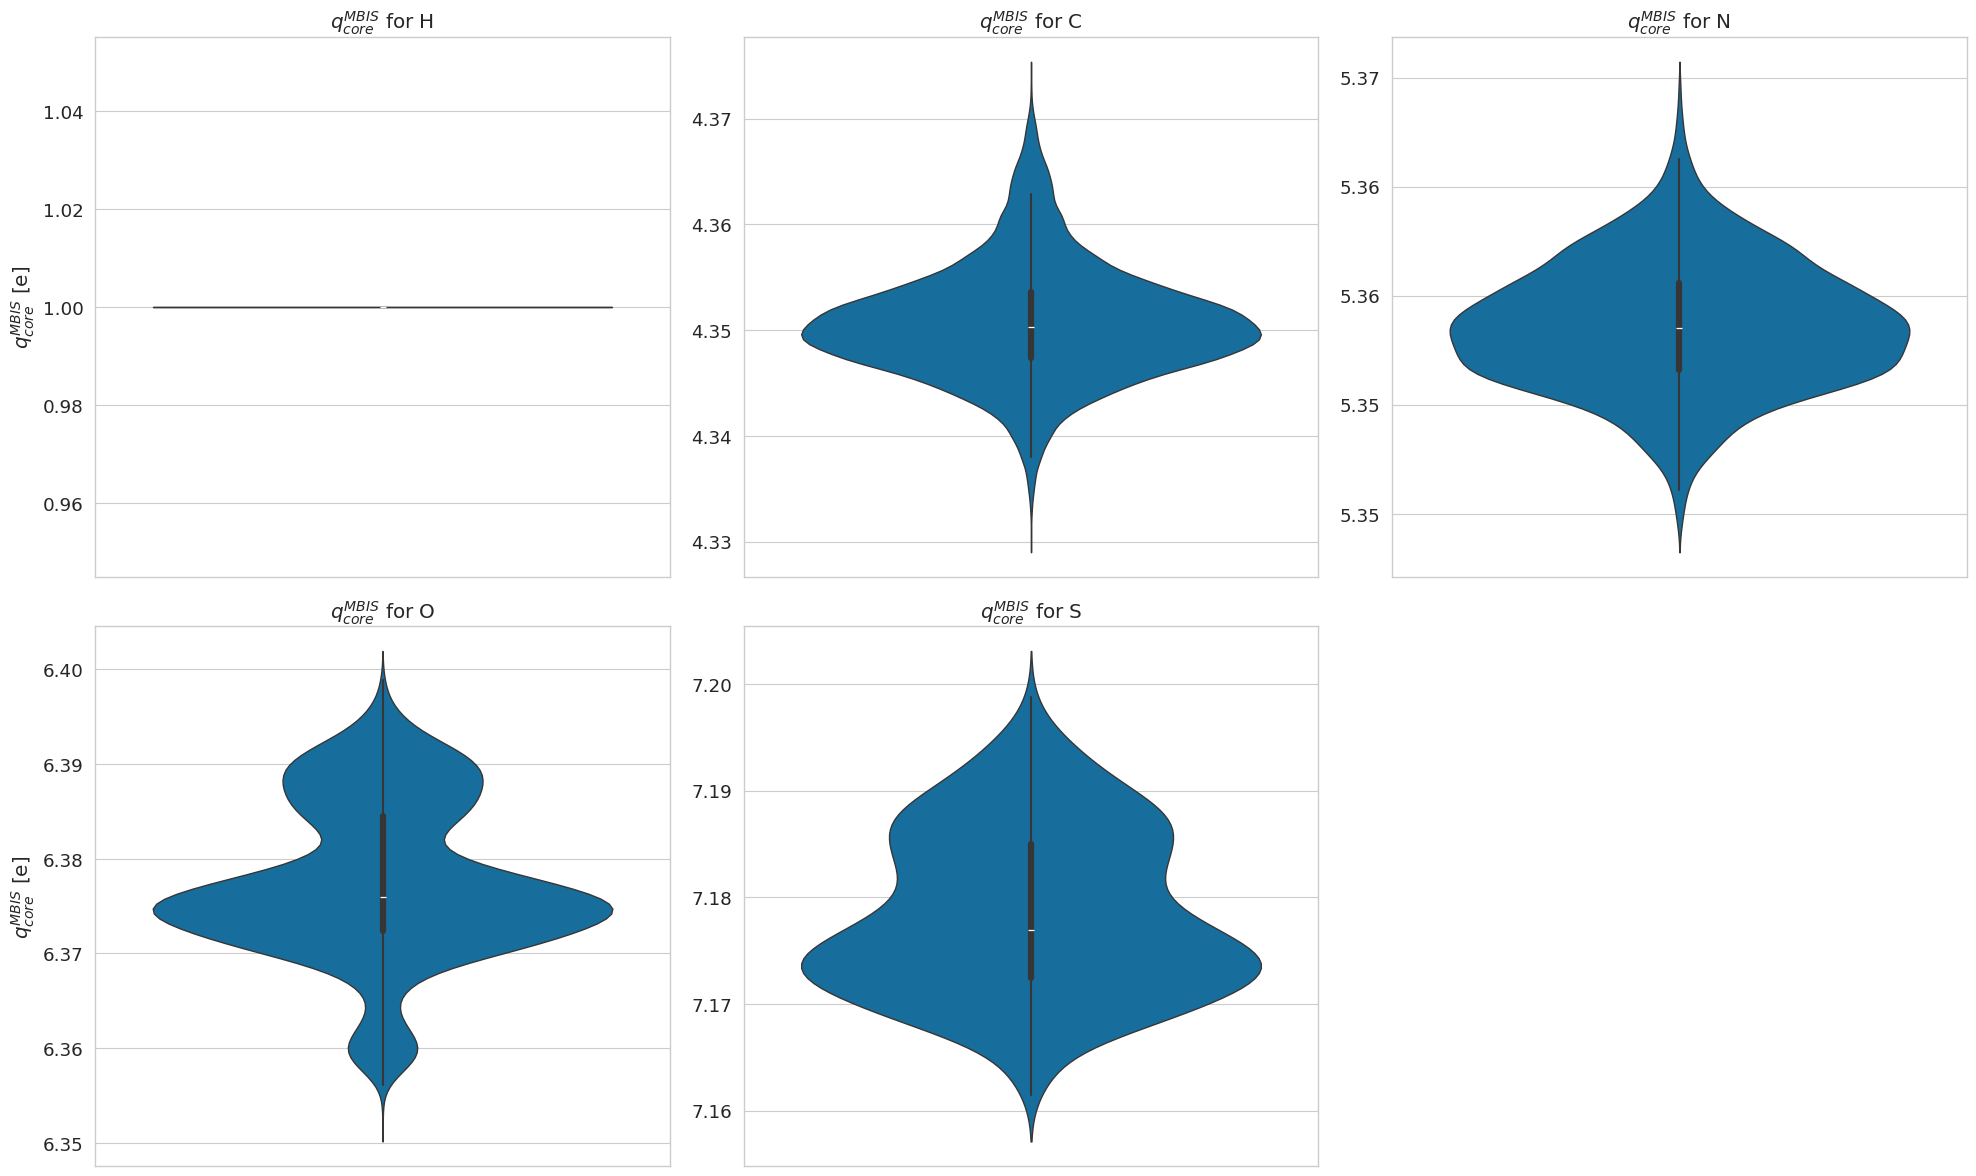

In [7]:
q_core_dict = {
    "H": q_core_ref[z == 1].detach().numpy(),
    "C": q_core_ref[z == 6].detach().numpy(),
    "N": q_core_ref[z == 7].detach().numpy(),
    "O": q_core_ref[z == 8].detach().numpy(),
    "S": q_core_ref[z == 16].detach().numpy(),
}

df = pd.DataFrame(
    [(e, v) for e, vals in q_core_dict.items() for v in vals],
    columns=["Element", "Value"],
)

sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.5)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (ax, element) in enumerate(zip(axes, q_core_dict.keys())):
    sns.violinplot(x="Element", y="Value", data=df[df["Element"] == element], ax=ax)
    ax.set_title(f"$q_{{core}}^{{MBIS}}$ for {element}")
    ax.set_xticks([])
    ax.set_ylabel("$q_{{core}}^{{MBIS}}$ [e]" if idx % 3 == 0 else "")
    ax.set_xlabel("")
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))

fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig("fig_q_core_distribution_violin.pdf", bbox_inches="tight", dpi=300)

# MBIS/DFT Analysis

In [8]:
data = []
rmse_values = {}

s_ref = s_ref.detach().numpy().flatten()
q_ref = q_val_ref.detach().numpy().flatten() + q_core_ref.detach().numpy().flatten()
alpha_ref = alpha_ref.detach().numpy().flatten()

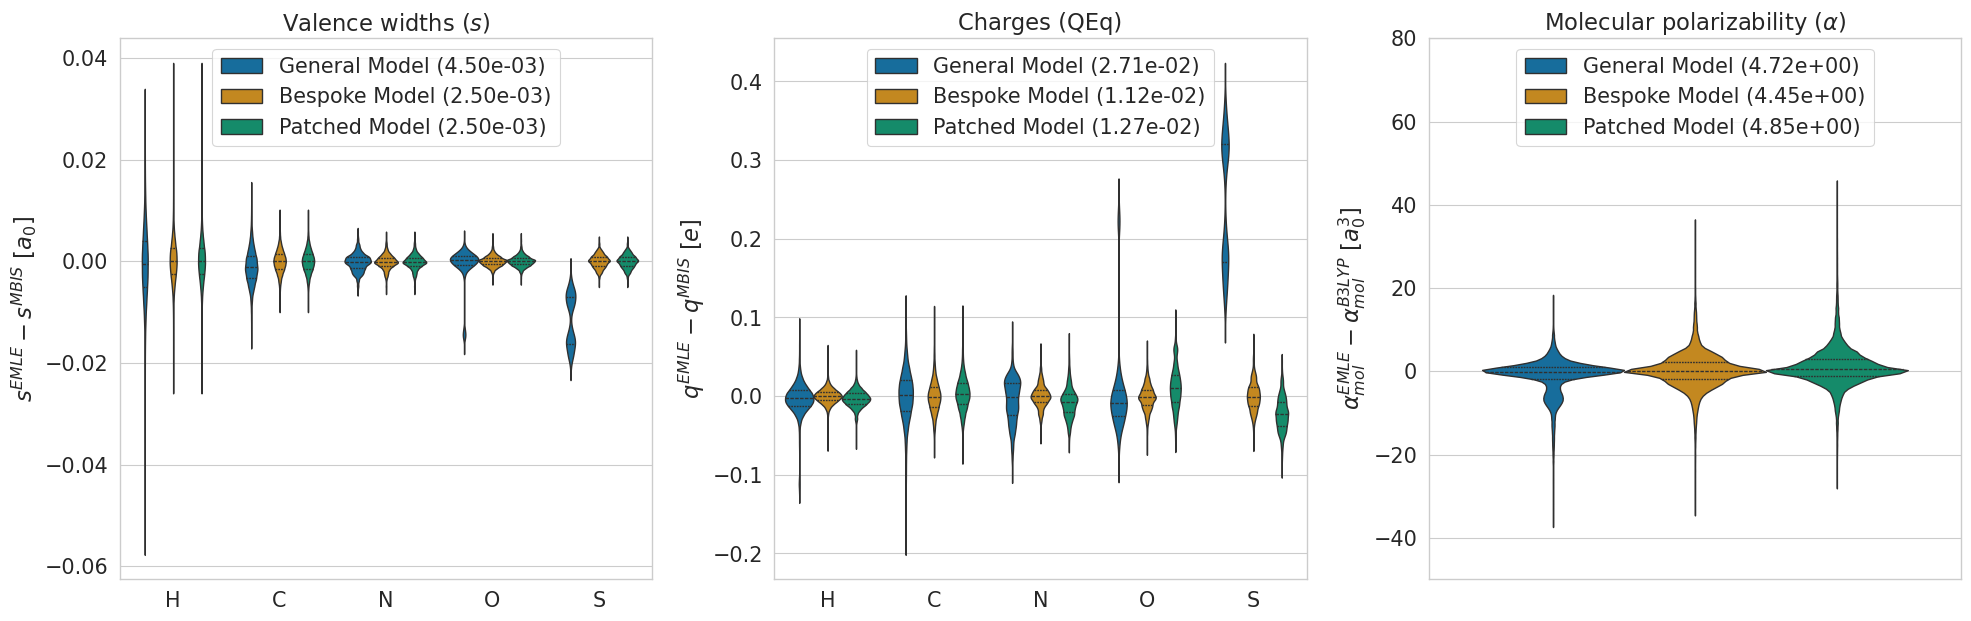

In [15]:
for model_name, mbis in emle_mbis_dict.items():
    s_pred = mbis["s"].flatten()
    rmse_values[model_name] = {"S": calculate_rmse(s_pred, s_ref)}

    for atom, mask in atomic_masks.items():
        data.extend(
            [
                {
                    "Model": model_name,
                    "Atom": atom,
                    "Difference": v,
                    "Type": "S vs Sref",
                }
                for v in (s_pred - s_ref)[mask]
            ]
        )

    q_pred = mbis["q_val"].flatten() + mbis["q_core"].flatten()
    rmse_values[model_name]["Charge"] = calculate_rmse(q_pred, q_ref)

    for atom, mask in atomic_masks.items():
        data.extend(
            [
                {"Model": model_name, "Atom": atom, "Difference": v, "Type": "Charges"}
                for v in (q_pred - q_ref)[mask]
            ]
        )

    alpha_pred = mbis["alpha"].flatten()
    rmse_values[model_name]["Polarizability"] = calculate_rmse(alpha_pred, alpha_ref)

    data.extend(
        [
            {
                "Model": model_name,
                "Atom": "All",
                "Difference": v,
                "Type": "Polarizability",
            }
            for v in alpha_pred - alpha_ref
        ]
    )

sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.7)
df = pd.DataFrame(data)
fig, axes = plt.subplots(1, 3, figsize=(20, 6.5))

plot_configs = [
    ("S vs Sref", "Valence widths ($s$)", "$s^{EMLE}-s^{MBIS}$ [$a_0$]", "S"),
    ("Charges", "Charges (QEq)", r"$q^{EMLE}-q^{MBIS}$ [$e$]", "Charge"),
    (
        "Polarizability",
        r"Molecular polarizability ($\alpha$)",
        r"$\alpha^{EMLE}_{mol}-\alpha^{B3LYP}_{mol}$ [$a_0^3$]",
        "Polarizability",
    ),
]

for ax, (type_, title, ylabel, rmse_key) in zip(axes, plot_configs):
    sns.violinplot(
        x="Atom",
        y="Difference",
        hue="Model",
        data=df[df["Type"] == type_],
        ax=ax,
        split=False,
        inner="quart",
        palette="colorblind",
    )
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")

    if type_ == "Polarizability":
        ax.set_xticklabels([])
        ax.set_ylim(-50, 80)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = [f"{label} ({rmse_values[label][rmse_key]:.2e})" for label in labels]
    ax.legend(handles=handles, labels=new_labels, loc="upper center")

plt.tight_layout()
plt.savefig("fig_mbis_dft_analysis.pdf", dpi=300, bbox_inches="tight")